In [1]:
# Importing necessary libraries for image processing and deep learning

# TensorFlow and Keras for building the neural network
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Scikit-learn for model evaluation and data splitting
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# OpenCV for image processing
import cv2

# NumPy for numerical operations
import numpy as np

# Matplotlib for data visualization
from matplotlib import pyplot as plt

# OS for file handling (make sure you're using it)
import os


In [2]:
# functions for image processing
def plot_many_images(images, titles='', rows=9, columns=9):
    #Plots each image in a given list as a grid structure. using Matplotlib.
    plt.title('Extracted elements from sudoku') 
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.axis('off')
    plt.show()

In [3]:
import matplotlib.pyplot as plt

def show_image(img, title='', flag=0):
    
    # If flag is non-zero, return True (the flag functionality isn't fully clear yet)
    if flag != 0:
        return True
    
    # Display the image with the given title
    plt.imshow(img, cmap='gray')  # Show the image in grayscale
    plt.title(title)  # Set the title
    plt.axis('off')  # Hide the axis
    plt.show()  # Block until the window is closed (default behavior)


In [4]:
import cv2
import numpy as np

def pre_process_image(img, skip_dilate=False, flag=0, blur_kernel_size=(9, 9), block_size=11, C=2):
    

    # Apply Gaussian blur with the specified kernel size
    proc = cv2.GaussianBlur(img.copy(), blur_kernel_size, 0)

    # Apply adaptive thresholding with the given block size and C value
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)

    # Invert the colors so gridlines become non-zero
    proc = cv2.bitwise_not(proc)

    if not skip_dilate:
        # Dilate the image to increase the size of the grid lines
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
        proc = cv2.dilate(proc, kernel)

    # Show the processed image
    show_image(proc, 'pre-processed above image to binary for contour detection', flag)
    return proc


In [5]:
import cv2
import numpy as np
import operator

def find_corners_of_largest_polygon(img):
    
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    if not contours:
        return None  # Return None if no contours are found
    
    # Sort contours by area, descending
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Approximate the largest contour to a polygon with 4 vertices
    polygon = contours[0]
    epsilon = 0.02 * cv2.arcLength(polygon, True)  # Approximation accuracy
    approx = cv2.approxPolyDP(polygon, epsilon, True)
    
    # Check if the polygon has 4 vertices (quadrilateral)
    if len(approx) != 4:
        return None  # If it's not a quadrilateral, return None
    
    # Extract the 4 corner points
    points = approx.reshape(4, 2)
    
    # Sort points to get the top-left, top-right, bottom-left, and bottom-right
    points = sorted(points, key=lambda x: x[0])  # Sort by x-coordinate (left to right)
    
    # Split into left and right based on x-coordinates
    left_points = sorted(points[:2], key=lambda x: x[1])  # Sort the left points by y (top to bottom)
    right_points = sorted(points[2:], key=lambda x: x[1])  # Sort the right points by y (top to bottom)
    
    # Return the ordered corners: top-left, top-right, bottom-right, bottom-left
    return [left_points[0], right_points[0], right_points[1], left_points[1]]



In [6]:
import numpy as np
import cv2

def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, crop_rect, flag=0):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect

    # Explicitly set the data type to float32 for the transformation matrix
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Calculate distances between the corners (only once per pair)
    top_side = distance_between(top_left, top_right)
    right_side = distance_between(top_right, bottom_right)
    bottom_side = distance_between(bottom_left, bottom_right)
    left_side = distance_between(top_left, bottom_left)

    # Get the longest side in the rectangle to determine square size
    side = max(top_side, right_side, bottom_side, left_side)

    # Define a square with side length equal to the longest side
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Get the perspective transformation matrix
    m = cv2.getPerspectiveTransform(src, dst)
    
    if m is not None:
        # Perform the transformation on the original image
        warp = cv2.warpPerspective(img, m, (int(side), int(side)))

        # Display the result using show_image (assuming show_image is defined elsewhere)
        show_image(warp, 'extracted and warped sudoku from the above image', flag)

        return warp
    else:
        print("Error: Perspective transformation failed.")
        return None


In [7]:

def infer_grid(img):
    """Infers 81 cell grid from a square image."""
    squares = []
    
    # Ensure the image is square
    height, width = img.shape[:2]
    if height != width:
        raise ValueError("Input image must be square")

    side = width / 9  # We can use width or height as they are the same

    # Loop to generate coordinates for each square in the grid
    for j in range(9):
        for i in range(9):
            # Top-left corner (x, y)
            p1 = (i * side, j * side)
            # Bottom-right corner (x, y)
            p2 = ((i + 1) * side, (j + 1) * side)
            squares.append((p1, p2))
    
    return squares

def cut_from_rect(img, rect):
    """Cuts a rectangle from an image using the top left and bottom right points."""
    
    # Get the rectangle's top left and bottom right coordinates
    x1, y1 = rect[0]
    x2, y2 = rect[1]
    
    # Ensure the coordinates are within the bounds of the image
    height, width = img.shape[:2]
    
    x1, x2 = max(0, x1), min(x2, width)
    y1, y2 = max(0, y1), min(y2, height)
    
    # Return the cropped region
    return img[int(y1):int(y2), int(x1):int(x2)]



In [8]:
import cv2

def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centers an image onto a new background square."""
    h, w = img.shape[:2]

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        """Scales a dimension by a given ratio."""
        return int(r * x)

    # Handle scaling and padding based on aspect ratio
    if h > w:  # Image is taller than wide
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:  # Image is wider or square
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    # Resize the image to fit within the scaled square
    img = cv2.resize(img, (w, h))

    # Add padding to center the image on the background
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)

    # Resize to the final size (if necessary)
    return cv2.resize(img, (size, size))



In [9]:
import cv2
import numpy as np

def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
    """
    Finds the largest connected feature in the input image using floodFill.
    Fills this structure in white and reduces the rest to black.
    """
    img = inp_img.copy()  # Copy the image to preserve original
    height, width = img.shape[:2]

    max_area = 0
    seed_point = None

    if scan_tl is None:
        scan_tl = [0, 0]  # Default to top-left corner
    if scan_br is None:
        scan_br = [width, height]  # Default to bottom-right corner

    # Iterate through the image to find the largest connected component
    for x in range(scan_tl[0], scan_br[0]):
        for y in range(scan_tl[1], scan_br[1]):
            if img.item(y, x) == 255:  # Look for white pixels
                area = cv2.floodFill(img, None, (x, y), 64)  # Flood-fill and get area size
                if area[0] > max_area:
                    max_area = area[0]
                    seed_point = (x, y)  # Update the seed point

    # Second pass: fill everything with grey to reduce noise and focus on the largest feature
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255:
                cv2.floodFill(img, None, (x, y), 64)

    # Create a mask for flood-filling the main feature
    mask = np.zeros((height + 2, width + 2), np.uint8)

    if seed_point is not None:
        cv2.floodFill(img, mask, seed_point, 255)  # Highlight the largest feature

    # Calculate the bounding box around the largest feature
    top, bottom, left, right = height, 0, width, 0
    for x in range(width):
        for y in range(height):
            if img.item(y, x) == 255:  # Find pixels belonging to the largest feature
                top = min(top, y)
                bottom = max(bottom, y)
                left = min(left, x)
                right = max(right, x)

    # Return the processed image and the bounding box
    bbox = np.array([[left, top], [right, bottom]], dtype='float32')
    return img, bbox, seed_point


In [10]:
def extract_digit(img, rect, size, min_area=100, margin_factor=2.5):
    """Extracts a digit (if one exists) from a Sudoku square."""
    
    digit = cut_from_rect(img, rect)  # Extract the region containing the digit

    # Use feature finding to get the largest feature in the center of the box
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / margin_factor)  # Dynamic margin calculation
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])

    # Crop the digit using the bounding box
    digit = cut_from_rect(digit, bbox)

    # Calculate the dimensions of the bounding box
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]

    # Ensure the bounding box area is large enough
    if w > 0 and h > 0 and (w * h) > min_area and len(digit) > 0:
        return scale_and_centre(digit, size, 4)  # Scale and center the digit
    else:
        return np.zeros((size, size), np.uint8)  # Return an empty square if no valid digit found


In [11]:
def get_digits(img, squares, size, flag=0):
    """Extracts digits from their cells and builds an array."""
    digits = []
    img = pre_process_image(img.copy(), skip_dilate=True, flag=flag)
    ii = img.copy()
    ii = cv2.cvtColor(ii, cv2.COLOR_GRAY2BGR)
    
    # Loop through the squares and extract digits
    for square in squares:
        # Extract the digit from the current square
        extracted_digit = extract_digit(img, square, size)
        
        # If the extracted digit is not empty, add it to the digits list
        if np.sum(extracted_digit) > 0:  # Check if the digit is non-empty
            digits.append(extracted_digit)
        else:
            digits.append(np.zeros((size, size), np.uint8))  # Placeholder for empty cells
        
        # Draw a rectangle around the current square
        a, b = (int(square[0][0]), int(square[0][1])), (int(square[1][0]), int(square[1][1]))
        cv2.rectangle(ii, a, b, (0, 255, 0), 3)
    
    # Show the image with grid lines marked in green
    #if flag:  # Only display if flag is non-zero
    show_image(ii, 'Grid lines marked in green (digits to extract will be in between)', flag)
    
    return digits


In [12]:
# Function to parse the grid from the loaded image
def parse_grid_from_loaded_image(img, flag=0):
    original = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rgb_img = cv2.cvtColor(original.copy(), cv2.COLOR_BGR2RGB)
    show_image(original, 'original image', flag)

    processed = pre_process_image(original, flag=flag)
    corners = find_corners_of_largest_polygon(processed)
    cv2.line(rgb_img, tuple(corners[0]), tuple(corners[1]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[1]), tuple(corners[2]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[2]), tuple(corners[3]), (255,0,0), 3)
    cv2.line(rgb_img, tuple(corners[3]), tuple(corners[0]), (255,0,0), 3)
    show_image(rgb_img, 'sudoku to extract', flag)
    
    cropped = crop_and_warp(original, corners, flag)
    squares = infer_grid(cropped)
    digits = get_digits(cropped, squares, 28, flag=flag)
    warp_img = cv2.cvtColor(cropped.copy(), cv2.COLOR_BGR2RGB)
    for a,b in squares:
        x,y = int(a[0]), int(a[1])
        w,z = int(b[0]), int(b[1])
        cv2.circle(warp_img, (x,y), 7, (220,0,30), -1)
    show_image(warp_img, 'intersection of the green lines marked in red dot', flag)
    return digits

Selected Image: image1003.jpg


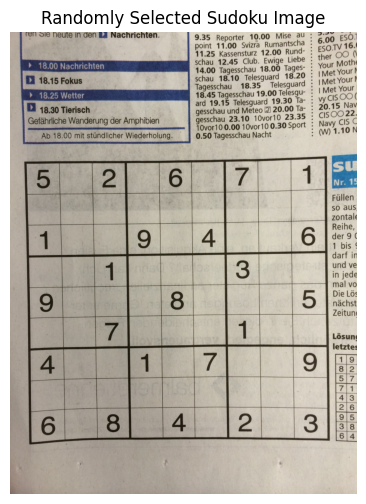

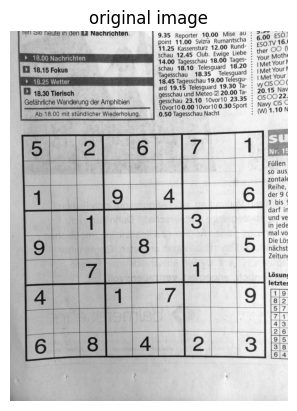

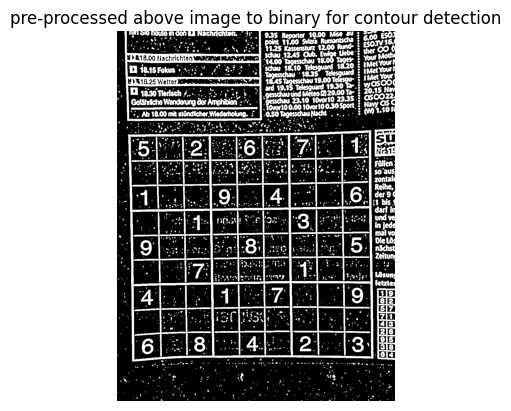

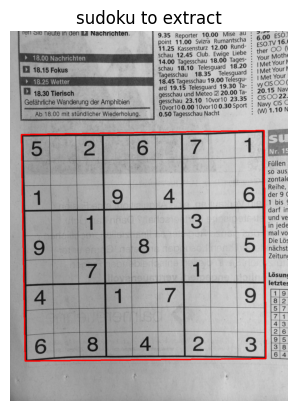

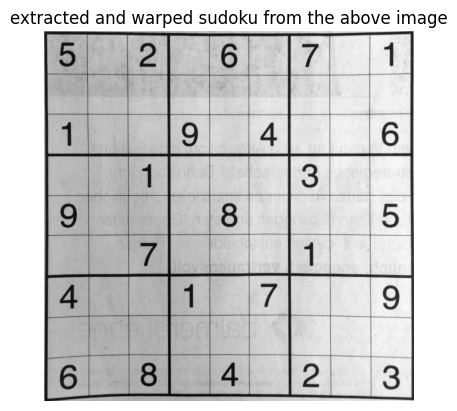

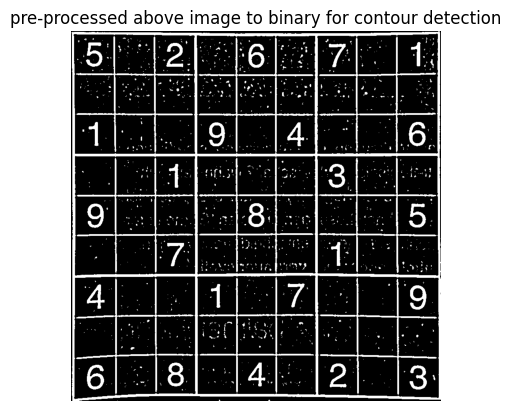

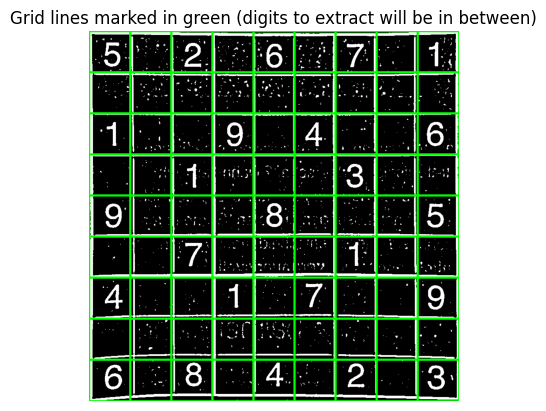

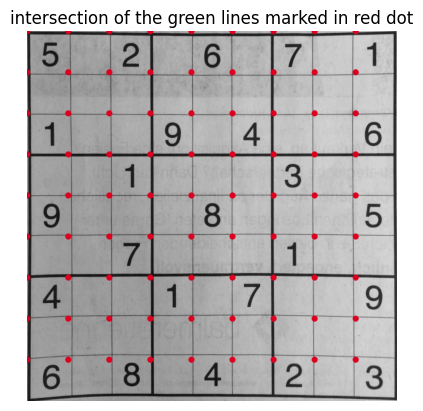

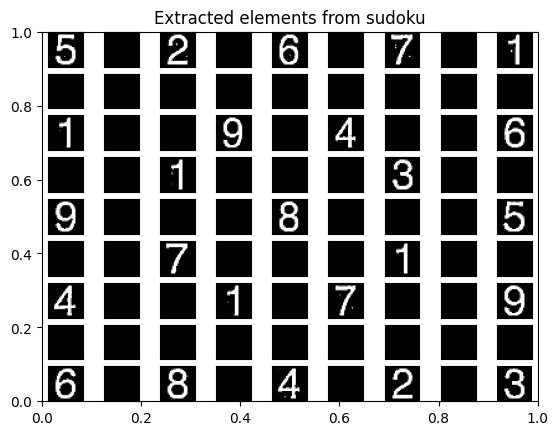

In [13]:
import os
import cv2
import random
import matplotlib.pyplot as plt



# Specify the folder containing the images
folder = "D:\\Codes\\Notebooks\\s_puzzle"

# Randomly select an image from the dataset 167

#image_name = random.choice(os.listdir(folder))

image_name="image1003.jpg"


print("Selected Image:", image_name)

# Load the selected image
sudoku_image = cv2.imread(os.path.join(folder, image_name))

# Check if the image is loaded successfully
if sudoku_image is not None:
    # Convert BGR to RGB (since OpenCV loads images in BGR format)
    sudoku_image = cv2.cvtColor(sudoku_image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))  # Optional: specify the figure size
    plt.imshow(sudoku_image)
    plt.axis('off')  # Hide axis
    plt.title("Randomly Selected Sudoku Image")  # Optional: add title
    plt.show()

    # Process the image to extract digits
    digits = parse_grid_from_loaded_image(sudoku_image, flag=0)

    # Plot the extracted digits in a grid (Assuming digits are a list of images)
    plot_many_images(digits)

else:
    print("Error: Unable to load the image.")


In [14]:
from tensorflow.keras.models import load_model

# Load the model without the optimizer state
model = load_model('digits_recognition_cnn.h5', compile=False)


In [15]:

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def is_valid_sudoku(grid, row, col, num):
    """Check if placing `num` at grid[row][col] is valid as per Sudoku rules."""
    # Check row
    if num in grid[row, :]:
        return False
    # Check column
    if num in grid[:, col]:
        return False
    # Check 3x3 subgrid
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    if num in grid[start_row:start_row + 3, start_col:start_col + 3]:
        return False
    return True

def preprocess_and_predict_digits(digits, model, grid_size=(9, 9)):
    """Preprocess the digits and predict numbers using the pre-trained model, storing results in a 2D grid."""
    predictions = np.zeros(grid_size, dtype=int)  # Initialize a 2D array of zeros with the grid size

    idx = 0  # Index to track the position in the 2D grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            digit = digits[idx]  # Extract the digit
            idx += 1

            # Check if the digit is empty (sum of pixel values is 0 or near 0)
            if np.sum(digit) == 0:  # Empty block, no digit present
                predictions[i, j] = 0  # Store 0 for empty cells
            else:
                # Resize the digit image to 28x28 (if not already)
                digit_resized = cv2.resize(digit, (28, 28))

                # Convert to grayscale if it's not
                if len(digit_resized.shape) == 3:
                    digit_resized = cv2.cvtColor(digit_resized, cv2.COLOR_BGR2GRAY)

                # Normalize the image (if the model was trained with normalized data)
                digit_resized = digit_resized.astype('float32') / 255.0

                # Reshape to match the model input shape (batch size, height, width, channels)
                digit_resized = np.expand_dims(digit_resized, axis=-1)  # Adding channel dimension
                digit_resized = np.expand_dims(digit_resized, axis=0)  # Adding batch size dimension

                # Get the prediction for the digit
                prediction = model.predict(digit_resized)
                predicted_digit = np.argmax(prediction)  # Get the index of the highest probability
                predictions[i, j] = predicted_digit

    # Correct misclassified digits selectively
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Skip correction for position (8, 4) (0-based index)
            if (i, j) == (8, 4):
                continue

            if predictions[i, j] == 9:
                # Check if replacing 9 with 4 is valid
                if is_valid_sudoku(predictions, i, j, 4) and not is_valid_sudoku(predictions, i, j, 9):
                    predictions[i, j] = 4
            elif predictions[i, j] == 4:
                # Check if replacing 4 with 9 is valid
                if is_valid_sudoku(predictions, i, j, 9) and not is_valid_sudoku(predictions, i, j, 4):
                    predictions[i, j] = 9

    ######
    predictions = np.where(predictions == 7, -1, predictions)  
    predictions = np.where(predictions == 1, 7, predictions)  
    predictions = np.where(predictions == -1, 1, predictions)  

    return predictions

def plot_predicted_digits(digits, predictions):
    """Plot the digits with their predicted values."""
    plt.figure(figsize=(9, 9))
    idx = 0  # Index to track the position of the digit
    for i in range(predictions.shape[0]):
        for j in range(predictions.shape[1]):
            plt.subplot(9, 9, idx + 1)
            plt.imshow(digits[idx], cmap='gray')
            plt.title(predictions[i, j])
            plt.xticks([]), plt.yticks([])  # Hide axis
            idx += 1
    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


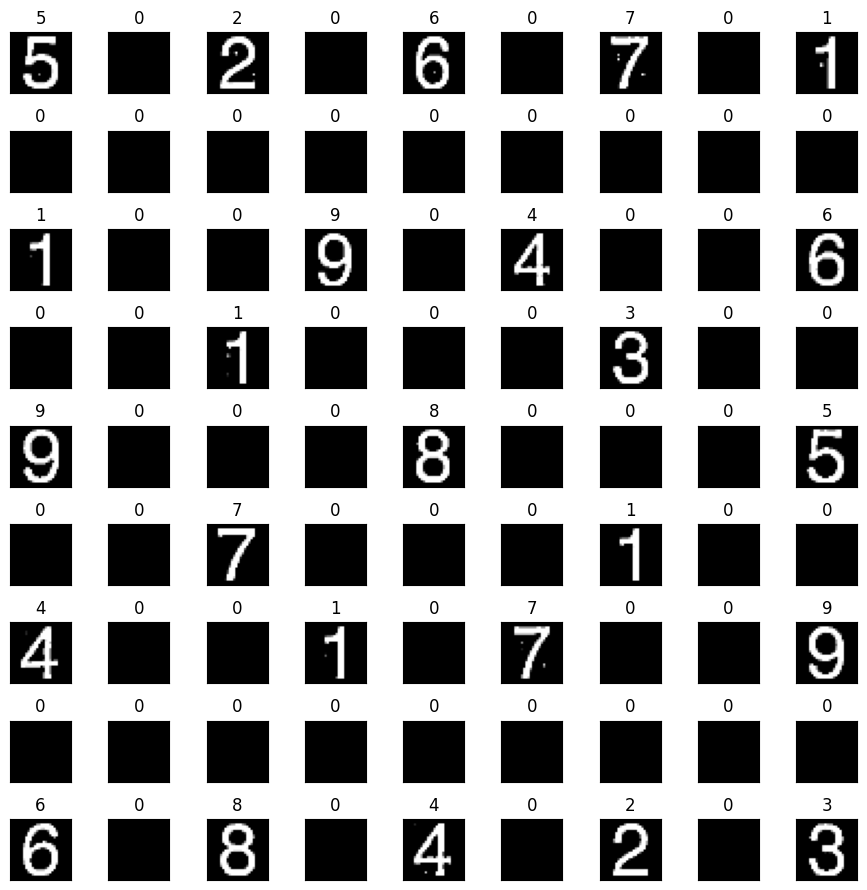

In [16]:
# Get predictions in 2D array form
predictions = preprocess_and_predict_digits(digits, model)

# Plot the digits with their predicted numbers
plot_predicted_digits(digits, predictions)


In [17]:
# Print the predictions 2D array (Sudoku grid)
print("Predictions (2D array):")
print(predictions)

Predictions (2D array):
[[5 0 2 0 6 0 7 0 1]
 [0 0 0 0 0 0 0 0 0]
 [1 0 0 9 0 4 0 0 6]
 [0 0 1 0 0 0 3 0 0]
 [9 0 0 0 8 0 0 0 5]
 [0 0 7 0 0 0 1 0 0]
 [4 0 0 1 0 7 0 0 9]
 [0 0 0 0 0 0 0 0 0]
 [6 0 8 0 4 0 2 0 3]]


In [18]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


def is_valid(board, row, col, num):
    """Check if it's a valid move to place 'num' at (row, col)."""
    # Check the row and column
    if num in board[row] or num in board[:, col]:
        return False

    # Check the 3x3 sub-grid
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    for i in range(3):
        for j in range(3):
            if board[start_row + i, start_col + j] == num:
                return False
    return True

def solve_sudoku(board):
    """Solve the Sudoku puzzle using backtracking."""
    for row in range(9):
        for col in range(9):
            if board[row, col] == 0:  # Find an empty cell
                for num in range(1, 10):
                    if is_valid(board, row, col, num):
                        board[row, col] = num  # Try this number
                        if solve_sudoku(board):  # Recursively solve the rest
                            return True
                        board[row, col] = 0  # Backtrack if not valid
                return False  # If no valid number found, backtrack
    return True  # Puzzle solved



# Print the predictions 2D array (Sudoku grid)
print("Predictions (2D array):")
print(predictions)

# Solve the Sudoku puzzle
if solve_sudoku(predictions):
    print("\nSudoku Solved:")
    print(predictions)
else:
    print("No solution exists")




Predictions (2D array):
[[5 0 2 0 6 0 7 0 1]
 [0 0 0 0 0 0 0 0 0]
 [1 0 0 9 0 4 0 0 6]
 [0 0 1 0 0 0 3 0 0]
 [9 0 0 0 8 0 0 0 5]
 [0 0 7 0 0 0 1 0 0]
 [4 0 0 1 0 7 0 0 9]
 [0 0 0 0 0 0 0 0 0]
 [6 0 8 0 4 0 2 0 3]]

Sudoku Solved:
[[5 9 2 8 6 3 7 4 1]
 [7 4 6 2 1 5 9 3 8]
 [1 8 3 9 7 4 5 2 6]
 [8 6 1 7 5 2 3 9 4]
 [9 2 4 3 8 1 6 7 5]
 [3 5 7 4 9 6 1 8 2]
 [4 3 5 1 2 7 8 6 9]
 [2 1 9 6 3 8 4 5 7]
 [6 7 8 5 4 9 2 1 3]]


In [19]:
def print_sudoku_grid(grid):
    """Print the Sudoku grid in a nice format."""
    print("Solved Sudoku Grid:")
    for i in range(len(grid)):
        # Print horizontal line after every 3 rows
        if i % 3 == 0 and i != 0:
            print("-" * 21)
        row = ""
        for j in range(len(grid[i])):
            # Print vertical line after every 3 columns
            if j % 3 == 0 and j != 0:
                row += "| "
            row += f"{grid[i, j]} "
        print(row)


In [20]:

print_sudoku_grid(predictions)
# Solve the Sudoku puzzle
if solve_sudoku(predictions):
    print("\nSudoku Solved")
    
else:
    print("No solution exists")



Solved Sudoku Grid:
5 9 2 | 8 6 3 | 7 4 1 
7 4 6 | 2 1 5 | 9 3 8 
1 8 3 | 9 7 4 | 5 2 6 
---------------------
8 6 1 | 7 5 2 | 3 9 4 
9 2 4 | 3 8 1 | 6 7 5 
3 5 7 | 4 9 6 | 1 8 2 
---------------------
4 3 5 | 1 2 7 | 8 6 9 
2 1 9 | 6 3 8 | 4 5 7 
6 7 8 | 5 4 9 | 2 1 3 

Sudoku Solved
